# Fig: MET against normalized degree heterogeneity
ISHII Hidemasa

In [1]:
using Statistics, CSV, DataFrames, DataFramesMeta
using DifferentialEquations, DiffEqCallbacks, Integrals
using CairoMakie
import ColorSchemes as cs

In [2]:
### new format for axes tick labels on log10 scale ###
digits_super = collect("⁰¹²³⁴⁵⁶⁷⁸⁹")
digits_sub = collect("₀₁₂₃₄₅₆₇₈₉")

function superscript(n::Integer; dsup=digits_super, dsub=digits_sub)
    if_pos = n >= 0
    if if_pos
        return join(dsup[begin .+ reverse(digits(n))])
    else
        return "⁻" * join(dsup[begin .+ reverse(digits(-n))])
    end
end

function log10format(value; digits=2, minabsexp=3)
    exponent = floor(Integer, log10(value))

    if abs(exponent) < minabsexp
        # no formatting for small value
        return "$(round(value, digits=max(1 - exponent, 1)))" 
    end

    coeff = round(value / 10.0^exponent, RoundNearestTiesUp; digits=digits)
    if coeff == 1
        return "10$(superscript(exponent))"
    else
        return "$(coeff)×10$(superscript(exponent))"
    end
end

log10format_vec(values; kwargs) = log10format.(values; kwargs...)

log10format_vec (generic function with 1 method)

In [3]:
datadir = "hpc-data"

r, D, ξ = (0.05, 0.005, 0.5)

(0.05, 0.005, 0.5)

In [4]:
""" return the unique value of a vector """
col2val(v) = only(unique(v))

function loadcsvs(fnamebase)
    df_p = CSV.read(joinpath(datadir, fnamebase * "_params.csv"), DataFrame)
    df_aet = CSV.read(joinpath(datadir, fnamebase * "_aet.csv"), DataFrame)

    # retrieve relevant values
    K = col2val(df_p.K)
    r = col2val(df_p.r)
    N = col2val(df_p.N)
    D = col2val(df_p.D)
    ξ = col2val(df_p.ξ)
    numsample = size(select(df_aet, Not(:id, :κ)), 2)

    # separate κ
    κ = df_aet.κ
    select!(df_aet, Not(:κ))

    return (; params=(; K, r, N, D, ξ, numsample), κ, df_aet, df_p)
end

loadcsvs (generic function with 1 method)

In [5]:
t_input = (
    K001 = (
        (fnamebase="K001/250925-192042", label="CBG256"),
        (fnamebase="K001/250926-094411", label="CBG512"),
        (fnamebase="K001/250926-073912", label="SSF256"),
        (fnamebase="K001/251007-153338", label="SSF512"),
        (fnamebase="K001/250926-081112", label="ER256"),
        (fnamebase="K001/251007-211606", label="ER512"),
        (fnamebase="K001/251010-103302", label="RRG256"),
        (fnamebase="K001/251010-105735", label="RRG512"),
    ),
    K01 = (
        (fnamebase="K01/250920-143558", label="CBG256"),
        (fnamebase="K01/250925-173024", label="CBG512"),
        (fnamebase="K01/250922-075729", label="SSF256"),
        (fnamebase="K01/250925-181332", label="SSF512"),
        (fnamebase="K01/250922-081531", label="ER256"),
        (fnamebase="K01/250925-184206", label="ER512"),
        (fnamebase="K01/251010-112915", label="RRG256"),
        (fnamebase="K01/251010-113547", label="RRG512"),
    ), 
    K1 = (
        (fnamebase="K1/251018-212710", label="CBG256"),
        (fnamebase="K1/251019-002540", label="CBG512"),
        (fnamebase="K1/251018-220428", label="SSF256"),
        (fnamebase="K1/251019-002514", label="SSF512"),
        (fnamebase="K1/251018-222806", label="ER256"),
        (fnamebase="K1/251019-000122", label="ER512"),
        (fnamebase="K1/251018-225907", label="RRG256"),
        (fnamebase="K1/251018-232650", label="RRG512"),
    ),
    K10 = (
        (fnamebase="K10/250920-145147", label="CBG256"),
        (fnamebase="K10/250922-153344", label="CBG512"),
        (fnamebase="K10/250921-231501", label="SSF256"),
        (fnamebase="K10/250923-225103", label="SSF512"),
        (fnamebase="K10/250922-083452", label="ER256"),
        (fnamebase="K10/250925-081601", label="ER512"),
        (fnamebase="K10/251010-114856", label="RRG256"),
        (fnamebase="K10/251010-153234", label="RRG512"),
    ),
    K100 = (
        (fnamebase="K100/251128-144600", label="CBG256"),
        (fnamebase="K100/251128-144601", label="SSF256"),
        (fnamebase="K100/251128-144602", label="ER256"),
        (fnamebase="K100/251128-144603", label="RRG256"),
    )
)

(K001 = ((fnamebase = "K001/250925-192042", label = "CBG256"), (fnamebase = "K001/250926-094411", label = "CBG512"), (fnamebase = "K001/250926-073912", label = "SSF256"), (fnamebase = "K001/251007-153338", label = "SSF512"), (fnamebase = "K001/250926-081112", label = "ER256"), (fnamebase = "K001/251007-211606", label = "ER512"), (fnamebase = "K001/251010-103302", label = "RRG256"), (fnamebase = "K001/251010-105735", label = "RRG512")), K01 = ((fnamebase = "K01/250920-143558", label = "CBG256"), (fnamebase = "K01/250925-173024", label = "CBG512"), (fnamebase = "K01/250922-075729", label = "SSF256"), (fnamebase = "K01/250925-181332", label = "SSF512"), (fnamebase = "K01/250922-081531", label = "ER256"), (fnamebase = "K01/250925-184206", label = "ER512"), (fnamebase = "K01/251010-112915", label = "RRG256"), (fnamebase = "K01/251010-113547", label = "RRG512")), K1 = ((fnamebase = "K1/251018-212710", label = "CBG256"), (fnamebase = "K1/251019-002540", label = "CBG512"), (fnamebase = "K1/251

## NlinMFFPE

In [6]:
### methods related to spatial discretization ###
"""generate an array of calculation points `x`"""
function get_x(a, b, Δx, ξ)
    #M = round(Int, (b - a) / Δx) + 1  # the number of data points
    x = [[a - Δx]; collect(a:Δx:b); [b + Δx]]  # extended x positions x0, x1, ..., x_{M+1}
    # warn if the choice of (a, b, Δx) is inappropriate
    if !(0 ∈ x) error("`x` does not contain `0` for a=$a, b=$b, Δx=$Δx") end
    if !(ξ ∈ x) error("`x` does not contain `ξ=$ξ` for a=$a, b=$b, Δx=$Δx") end
    if !(1 ∈ x) @warn "`x` does not contain `1`" a=a b=b Δx=Δx end
    return x
end

"""return the number of data points `M` from `x`"""
get_M(x) = length(x) - 2  # subtract the number of extended points

"""get the index of x = 0"""
idx_at0(x) = only(indexin(0, x))

"""get the index of x = ξ"""
idx_atξ(x, ξ) = only(indexin(ξ, x))

"""calculate the mean field X"""
@views calc_X(p, x, Δx) = sum(p[begin+1:end-1] .* x[begin+1:end-1]) * Δx

"""update p_0 and p_{M+1} to impose the no-flux boundary condition"""
@views function boundarycond!(p, param, X)
    (; K, D, Δx, x, f) = param  # expand parameters
    # p_0
    p[begin] = p[begin+2] - 2 * Δx / D * (
        f[begin] + K * (X - x[begin+1])
    ) * p[begin+1]
    # p_{M+1}
    p[end] = p[end-2] + 2 * Δx / D * (
        f[end] + K * (X - x[end-1])
    ) * p[end-1]
    return nothing
end

### define the system ###
bistable_flow(x, r) = -x * (x - r) * (x - 1)
dfdx(x, r) = -3 * x^2 + 2 * (1 + r) * x - r

@views function nlinmffpe!(dp, p, param, t)
    (; r, K, D, Δx, x, f, K_min_dfdx) = param  # expand parameters
    X = calc_X(p, x, Δx)  # mean field
    boundarycond!(p, param, X)  # impose boundary condition
    # update dot{p}_1, ..., dot{p}_M
    dp[begin+1:end-1] .= (
        K_min_dfdx .* p[begin+1:end-1]
        + (K * (x[begin+1:end-1] .- X) .- f) .* (
            (p[begin+2:end] .- p[begin:end-2]) / (2 * Δx)
        )
        + D * (p[begin+2:end] .+ p[begin:end-2] .- 2 * p[begin+1:end-1]) / (Δx^2)
    )
end

### helper methods to perform the numerical integration ###
"""generate a NamedTuple of parameters"""
@views function init_param(r, K, D, ξ, a, b, Δx, Jξmin)
    x = get_x(a, b, Δx, ξ)
    return init_param(r, K, D, ξ, Δx, Jξmin, x, 
        bistable_flow.(x[begin+1:end-1], r),  # f
        K .- dfdx.(x[begin+1:end-1], r),  # K_min_dfdx
    )
end

function init_param(r, K, D, ξ, Δx, Jξmin, x, f, K_min_dfdx)
    return (
        r=r, K=K, D=D, x=x, Δx=Δx, ξidx=idx_atξ(x, ξ), Jξmin=Jξmin, 
        f=f, K_min_dfdx=K_min_dfdx,
    )
end

"""initialize p(x) that has delta-peak at x=0"""
@views function init_p0(param)
    (; Δx, x) = param  # expand parameters
    init = zeros(length(x))
    init[idx_at0(x)] = 1 / Δx
    boundarycond!(init, param, calc_X(init, x, Δx))  # impose boundary condition
    return init
end

"""calculate the flux J_i"""
calc_Ji(p, param, i) = calc_Ji(p, param, i, calc_X(p, param.x, param.Δx))

calc_Ji(p, param, i, X) = (
    (param.f[i] + param.K * (X - param.x[begin+i])) * p[begin+i]
    - param.D * (p[begin+i+1] - p[begin+i-1]) / (2 * param.Δx)
)

"""return true if termination condition `X > 0.9 && Jξ < Jξmin` is satisfied"""
function terminate_cond(u, t, int)
    X = calc_X(u, int.p.x, int.p.Δx)
    return X > 0.9 && calc_Ji(u, int.p, int.p.ξidx, X) < int.p.Jξmin
end

# callback to terminate the simulation
terminate_cb = DiscreteCallback(
    terminate_cond, integrator -> terminate!(integrator); 
    save_positions=(true, false)  # only save the data just before termination
)

"""calculate X and Jξ upon saving"""
function savefunc_Jξ_X(u, t, int)
    X = calc_X(u, int.p.x, int.p.Δx)
    return (X, calc_Ji(u, int.p, int.p.ξidx, X))
end

"""main method"""
function solve_X_Jξ(param; terminate_cb=terminate_cb, kwargs...)
    p0 = init_p0(param)
    # set up SaveingCallback to save X and Jξ
    saved_values = SavedValues(Float64, Tuple{Float64, Float64})  # results 
    saving_cb = SavingCallback(savefunc_Jξ_X, saved_values, saveat=get(kwargs, :saveat, 0.1))
    # pack the Callbacks
    cbset = CallbackSet(saving_cb, terminate_cb)
    # numerical integration
    prob = ODEProblem(nlinmffpe!, p0, get(kwargs, :tspan, 1e4), param)
    sol = solve(prob, Tsit5(), abstol=1e-6, reltol=1e-3, save_everystep=false,
        callback=cbset, maxiters=5e6
    )
    if sol.retcode != ReturnCode.T(2)
        @warn "numerical integration was not terminated" retcode=sol.retcode
    end
    return (t=saved_values.t, u=hcat(collect.(saved_values.saveval)...))
end

"""calculate MET from a solution of NlinMFFPE"""
sol2met(sol, Δt) = @views sum(sol.t .* sol.u[2, :]) * Δt  # faster with view

sol2met

In [7]:
function gen_csv_FPE(; r=r, D=D, ξ=ξ, 
    a=-0.5, b=1.3, Δx=1e-3, Jξmin=1e-4, Δt=0.01
)
    # generate K values
    K_FPE = [0.01, 0.1, 1.0]

    # preparation
    x = get_x(a, b, Δx, ξ)
    f = bistable_flow.(@view(x[begin+1:end-1]), r)
    vec_dfdx = dfdx.(@view(x[begin+1:end-1]), r)

    # calculate MET
    T_FPE = Vector{Float64}(undef, length(K_FPE))
    for (i, K) in enumerate(K_FPE)
        println("K=$K ($i / $(length(K_FPE)))")
        param = init_param(
            r, K, D, ξ, Δx, Jξmin, x, f, K .- vec_dfdx
        )
        sol = solve_X_Jξ(param; saveat=Δt)
        T_FPE[i] = sol2met(sol, Δt)
    end
    #return "STOPPED FOR DEBUGGING"
    # export results and parameters
    CSV.write("output/251019-fpe-res.csv", DataFrame(K=K_FPE, T_FPE=T_FPE))
    CSV.write("output/251019-fpe-param.csv", DataFrame(
        a=[a], b=[b], Δx=[Δx], Jξmin=[Jξmin], Δt=[Δt]
    ))
    return nothing
end

gen_csv_FPE (generic function with 1 method)

In [8]:
# get predictions if needed
if_calc_FPE = false

if if_calc_FPE
    gen_csv_FPE()
end

In [9]:
function load_FPE_df()
    dfparam = CSV.read("output/251019-fpe-param.csv", DataFrame)
    dfres = CSV.read("output/251019-fpe-res.csv", DataFrame)
    return (
        fpe_param=(
            a=only(dfparam.a), 
            b=only(dfparam.b), 
            Δx=only(dfparam.Δx),
            Jξmin=only(dfparam.Jξmin),
            Δt=only(dfparam.Δt)
        ),
        K_FPE=dfres.K,
        T_FPE=dfres.T_FPE,
    )
end

load_FPE_df (generic function with 1 method)

In [10]:
(; fpe_param, K_FPE, T_FPE) = load_FPE_df();
d_fperes = Dict(zip(K_FPE, T_FPE))

Dict{Float64, Float64} with 3 entries:
  0.01 => 19.0422
  0.1  => 14.3633
  1.0  => 31.8046

## SMFD

In [11]:
"""calculate mean first passage time"""
function outer_integrand(u_tmp, y, p)
    (; V::Function, D::Real) = p  # expand parameters
    u_tmp[begin] = calc_inner_integral(only(y), V, D)
end

function inner_integrand(v_tmp, z, p)
    (; V::Function, D::Real, y::Real) = p  # expand parameters
    v_tmp[begin] = exp((V(y) - V(only(z))) / D)  # implementation here needs caution
end

function calc_inner_integral(y::Real, V::Function, D)
    prototype = zeros(1)
    domain = ([-Inf], [y])  # (lb, ub)
    p = (V=V, D=D, y=y)
    prob = IntegralProblem(IntegralFunction(inner_integrand, prototype), domain, p)
    sol = solve(prob, QuadGKJL(), reltol=1e-9,
        # abstol must be very small in cases of large N (i.e. small diff. coef. D / N)
        abstol=1e-44,
    )
    return only(sol.u)
end

function calc_mfpt(V::Function, D, ξ; lb=0.0)
    prototype = [10.0]
    domain = ([lb], [ξ])  # (lb, ub)
    p = (V=V, D=D)
    prob = IntegralProblem(IntegralFunction(outer_integrand, prototype), domain, p)
    sol = solve(prob, QuadGKJL(), abstol=1e-10, reltol=1e-8)
    return only(sol.u) / D
end

calc_mfpt (generic function with 1 method)

In [12]:
simplify_flag = false

false

In [13]:
# assuming K - f'(Θ) ≈ K
if simplify_flag
    """potential of the isolated dynamics"""
    function V_iso(x, r=r)
        return x^4 / 4 - (1 + r) / 3 * x^3 + r / 2 * x^2
    end

    ### Stochastic Mean-Field Dynamics ###
    zstar(K, κ_N, D=D) = D / K * (1 - κ_N)

    function V_smfd(x, z, r=r)
        return x^4 / 4 - (1 + r) / 3 * x^3 + (r + 3z) / 2 * x^2 - (1 + r) * z * x
    end
end

# without assuming K - f'(Θ) ≈ K
if !simplify_flag
    dfdx(x; r=r) = -3 * x^2 + 2 * (1 + r) * x - r;

    """potential of the isolated dynamics"""
    function V_iso(x, r=r)
        return x^4 / 4 - (1 + r) / 3 * x^3 + r / 2 * x^2
    end

    ### Stochastic Mean-Field Dynamics ###
    zstar(K, Θ, κ_N, D=D) = D / (K - dfdx(Θ)) * (1 - κ_N)

    function V_smfd(x, K, κ_N, r=r)
        return x^4 / 4 - (1 + r) / 3 * x^3 + (r + 3 * zstar(K, x, κ_N)) / 2 * x^2 - (1 + r) * zstar(K, x, κ_N) * x
    end
end

V_smfd (generic function with 2 methods)

In [14]:
# limiting cases
T0 = calc_mfpt(V_iso, D, ξ)
T∞(κ_N) = calc_mfpt(V_iso, D * κ_N, ξ)

T∞ (generic function with 1 method)

In [15]:
# prediction of SMFD
vec_κN = collect(logrange(10^(-3.0), 10^(-0.25), 33))
T∞smfd = T∞.(vec_κN)

K1 = 1.0
K2 = 10.0
K3 = 100.0
T1smfd = Vector{Float64}(undef, length(vec_κN))
T2smfd = Vector{Float64}(undef, length(vec_κN))
T3smfd = Vector{Float64}(undef, length(vec_κN))

for (K, Tvec) in zip((K1, K2, K3), (T1smfd, T2smfd, T3smfd))
    for (j, κ_N) in enumerate(vec_κN)
        V_Θ(x) = if simplify_flag
            V_smfd(x, zstar(K, κ_N))
        else
            V_smfd(x, K, κ_N)
        end
        Tvec[j] = calc_mfpt(V_Θ, D * κ_N, ξ)
    end
end

In [16]:
d_smfdres = Dict(K1 => T1smfd, K2 => T2smfd, K3 => T3smfd)

Dict{Float64, Vector{Float64}} with 3 entries:
  10.0  => [385.204, 339.869, 302.155, 270.325, 243.125, 219.636, 199.165, 181.…
  1.0   => [29.1472, 29.172, 29.2018, 29.2377, 29.2806, 29.3317, 29.3922, 29.46…
  100.0 => [5382.46, 2880.83, 1724.45, 1127.72, 790.498, 585.038, 451.786, 360.…

## comparison: NlinMFFPE & SMFD

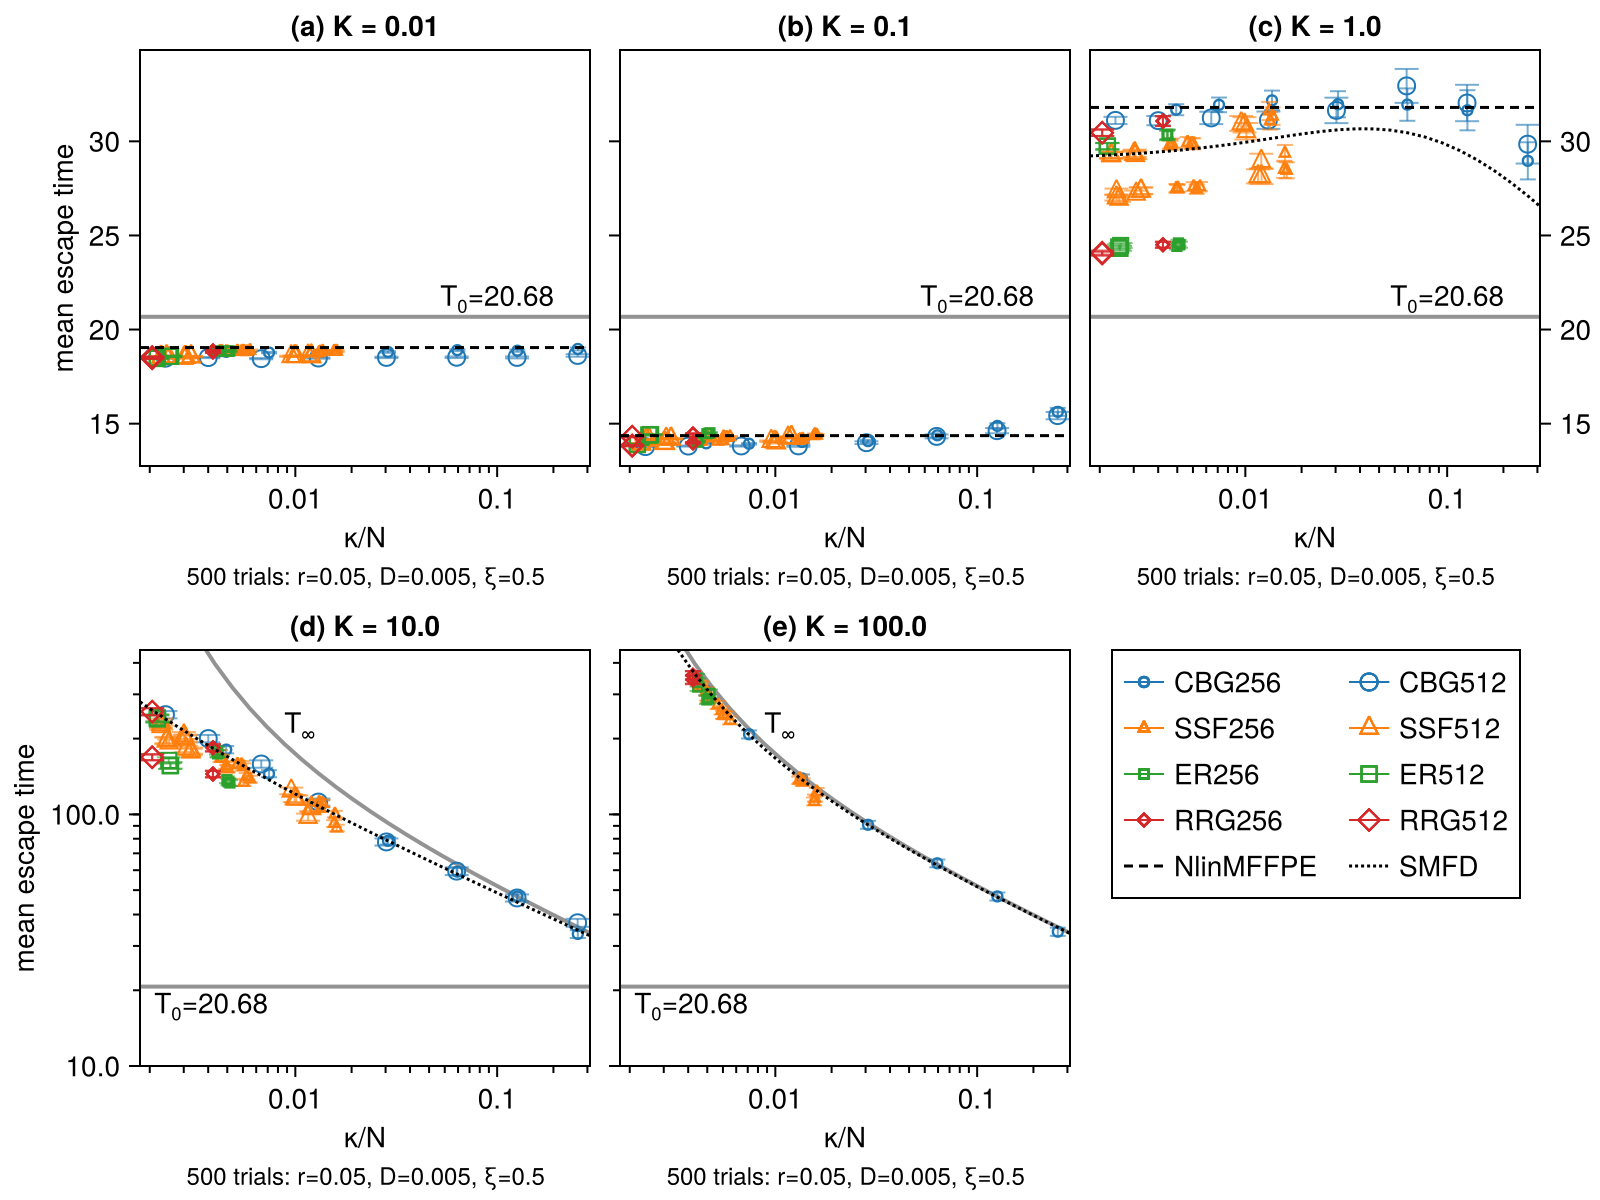

In [17]:
# show Standard Error as errorbars
let plt = cs.tab10, ifsave = true
    fig = Figure(size=(800, 600), figure_padding=5)

    # generate GridLayouts
    gl1 = fig[1, 1] = GridLayout()
    gl2 = fig[1, 2] = GridLayout()
    gl3 = fig[1, 3] = GridLayout()
    gl4 = fig[2, 1] = GridLayout()
    gl5 = fig[2, 2] = GridLayout()

    t_gl = (gl1, gl2, gl3, gl4, gl5)

    # # prepare Axes
    axopts = (
        xlabel="κ/N", xgridvisible=false, #xautolimitmargin=(0.02, 0.02),
        xscale=log10, xtickformat=vals -> log10format.(vals), 
        xticks=10.0 .^collect(-3:0),
        xminorticksvisible=true, xminorticks=IntervalsBetween(10),
        ygridvisible=false,
    )
    logaxopts = (axopts...,
        yscale=log10, ytickformat=vals -> log10format.(vals),
        yticks=10 .^collect(0:3), #yticklabelrotation=π/4,
        yminorticksvisible=true, 
        yminorticks=[collect(1:10); collect(20:10:100); collect(200:100:1000)],
    )
    ax1 = Axis(gl1[1, 1]; ylabel="mean escape time", axopts...)
    ax2 = Axis(gl2[1, 1]; yticklabelsvisible=false, axopts...)
    ax3 = Axis(gl3[1, 1]; yaxisposition=:right, axopts...)
    ax4 = Axis(gl4[1, 1]; ylabel="mean escape time", logaxopts...)
    ax5 = Axis(gl5[1, 1]; yticklabelsvisible=false, logaxopts...)

    t_ax = (ax1, ax2, ax3, ax4, ax5)
    t_axlbl = ("a", "b", "c", "d", "e")
    
    # ## link y axes
    for ax in (ax2, ax3)
        linkyaxes!(ax1, ax)
    end
    linkyaxes!(ax4, ax5)

    # ## manually fix ylims for K = 100.0 panel
    for ax in (ax4, ax5)
        ylims!(ax, 10, 450)
    end

    # ## link all x axes
    for ax in (ax2, ax3, ax4, ax5)
        linkxaxes!(ax1, ax)
    end

    # # plot data
    # ## T0 and T∞
    mfptcol = (:gray40, 0.7)
    mfptlw = 2
    for ax in (ax1, ax2, ax3)
        hlines!(ax, T0, color=mfptcol, linewidth=mfptlw)
        text!(ax, 0.1, T0; 
            text=rich("T", subscript("0"), "=$(round(T0, digits=2))"), 
            align=(:center, :bottom),
        )
    end

    annot_id = 12
    for ax in (ax4, ax5)
        # T0
        hlines!(ax, T0, color=mfptcol, linewidth=mfptlw)
        text!(ax, 0.002, T0; 
            text=rich("T", subscript("0"), "=$(round(T0, digits=2))"), 
            align=(:left, :top),
        )
        #T∞
        lines!(ax, vec_κN, T∞smfd; color=mfptcol, linewidth=mfptlw)
        text!(ax, vec_κN[annot_id], T∞smfd[annot_id];
            text=rich("T", subscript("∞")), 
            align=(:left, :bottom),
        )
    end

    # ## preparation
    # record range of κ/N
    minκ_N, maxκ_N = [0.0, 1.0]
    recorded_minmax = false

    d_elem = Dict{String, Any}()

    d_color = Dict(
        :cbg=>cs.tab10[1], :ssf=>cs.tab10[2],
        :er=>cs.tab10[3], :rrg=>cs.tab10[4],
    )
    d_marker = Dict(
        :cbg=>:circle, :ssf=>:utriangle, :ba=>:dtriangle,
        :er=>:rect, :rrg=>:diamond
    )
    style256 = (markersize=7, strokewidth=1.2,)
    style512 = (markersize=12, strokewidth=1,)

    # ## METs
    for (j, (input, gl, ax, axlbl)) in enumerate(zip(t_input, t_gl, t_ax, t_axlbl))
        # load data: use Vector of Pairs to preserve the order in t_input
        v_data = []
        for (; fnamebase, label) in input
            push!(v_data, label => loadcsvs(fnamebase))
        end

        # calculate met and plot data
        Kval = -1.0
        labstr = ""
        
        for (label, data) in v_data
            (; K, N, r, D, ξ, numsample) = data.params

            if Kval < 0 Kval = K 
            else @assert Kval == K "K does not match!" end
            
            labstr_ = "$numsample trials: r=$r, D=$D, ξ=$ξ"
            if length(labstr) == 0 labstr = labstr_
            else @assert labstr == labstr_ "parameters do not match!" end

            ### set plot styles ###
            model = lowercase(label[begin:end-3])
            size = label[end-2:end]

            mk = d_marker[Symbol(model)]
            cl = d_color[Symbol(model)]
            sizeopts = size == "256" ? style256 : style512
            ww = size == "256" ? 8 : 12

            ### calculate relevant quantities ###
            κoverN = data.κ ./ N
            met = mean.(eachrow(select(data.df_aet, Not(:id))))
            se = std.(eachrow(select(data.df_aet, Not(:id)))) / sqrt(numsample)

            if !recorded_minmax
                minκ_N = minimum(κoverN)
                maxκ_N = maximum(κoverN)
                recorded_minmax = true
            else
                minκ_N = min(minκ_N, minimum(κoverN))
                maxκ_N = max(maxκ_N, maximum(κoverN))
            end

            ### plot range ###
            eb = errorbars!(ax, κoverN, met, se, 
                color=(cl, 0.6), linewidth=1, whiskerwidth=ww
            )

            ### plot MET ###
            sc = scatter!(ax, κoverN, met;
                marker=mk, color=(:black, 0), strokecolor=cl,
                label=label, sizeopts...
            )

            ### Legend preparation ###
            sclegopts = (; alpha=1)  #, strokewidth=1.5)
            if haskey(d_elem, label)
                push!(d_elem[label], eb)
                push!(d_elem[label], sc => sclegopts)
            else
                d_elem[label] = [eb, sc => sclegopts]
            end
        end

        ### prediction of NlinMFFPE, if applicable ###
        if haskey(d_fperes, Kval)
            l = hlines!(ax, d_fperes[Kval]; 
                color=:black, linestyle=(:dash, :dense), 
                linewidth=1.5,
            )
            d_elem["NlinMFFPE"] = l
        end

        if haskey(d_smfdres, Kval)
            l = lines!(ax, vec_κN, d_smfdres[Kval], 
                color=:black, linestyle=(:dot, :dense), 
                linewidth=1.5,
            )
            d_elem["SMFD"] = l
        end

        ax.title = "($(axlbl)) K = $Kval"
        Label(gl[2, 1], labstr, tellwidth=false, fontsize=12,)
        rowgap!(gl, 5)
    end

    # set xlim manually
    xlimitmargin = 0.1
    κoverN_log10width = abs(log10(maxκ_N - minκ_N))
    xlimlow = 10^(log10(minκ_N) - xlimitmargin * κoverN_log10width)
    xlimhigh = 10^(log10(maxκ_N) + xlimitmargin * κoverN_log10width)
    @debug xlimlow, minκ_N, maxκ_N, xlimhigh
    for ax in t_ax
        xlims!(ax, xlimlow, xlimhigh)
    end

    leglab = [
        "CBG256", "CBG512", "SSF256", "SSF512", "ER256", "ER512", "RRG256", "RRG512",
        "NlinMFFPE", "SMFD",
    ]
    Legend(fig[2, 3], [d_elem[lab] for lab in leglab], leglab, 
        nbanks=2, halign=:center, valign=:top, tellwidth=false,
    )
    rowgap!(fig.layout, 10)
    colgap!(fig.layout, 10)
    display(fig)
    if ifsave save("output/fig-met-vs-deghet.pdf", fig) end
end;